Anchor explanations for CIFAR-100 dataset using pretrained ImageNet

Links:

- https://docs.seldon.io/projects/alibi/en/stable/methods/Anchors.html

- https://docs.seldon.io/projects/alibi/en/stable/api/alibi.explainers.html#alibi.explainers.AnchorImage

- https://docs.seldon.io/projects/alibi/en/stable/examples/anchor_image_imagenet.html

Libraries

In [ ]:
 !pip install alibi

In [ ]:
# import libraries
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
#from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import smart_resize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar100 # for CIFAR-100 dataset

#from alibi.datasets import load_cats # images of various cat breeds
from alibi.explainers import AnchorImage
from skimage.segmentation import slic

Load model pre-trained on ImageNet

In [ ]:
#model = InceptionV3(weights = 'imagenet') # load InceptionV3
model = ResNet50(weights = 'imagenet') # load ResNet50

Load and pre-process sample images

In [ ]:
# set target size of image
image_shape = (224, 224, 3) # (224, 224, 3) for ResNet50; (299, 299, 3) for InceptionV3

In [ ]:
# load CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
NUM_CLASSES = 100

In [ ]:
# classes for CIFAR-100 dataset
cifar100_classes = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck',
'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon',
'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk',
'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower',
'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

In [ ]:
len(cifar100_classes)

100

In [ ]:
x_test.shape

(10000, 32, 32, 3)

apply image preprocessing, make predictions, map predictions back to categories

In [ ]:
# index for tested image
i = 20 # 15 for lion, 20 for rose

In [ ]:
resized_image = smart_resize(x_test[i], image_shape[:2])

In [ ]:
# check output
print(x_test[i].shape)
print(resized_image.shape)

(32, 32, 3)
(224, 224, 3)


In [ ]:
preprocessed_image = preprocess_input(np.expand_dims(resized_image, axis = 0))
#preds = model.predict(preprocessed_image)
#label = decode_predictions(preds, top=3)
#print(label[0])
preprocessed_image.shape

(1, 224, 224, 3)

In [ ]:
# explainer expects images in 0-1 range, CIFAR is 0-255 => scale valued between 0-1
# normalize input
norm_image = resized_image / 255.0

norm_image.shape

(224, 224, 3)

define prediction function

In [ ]:
predict_fn = lambda x: model.predict(x)

initialize anchor image explainer

In [ ]:
segmentation_fn = 'slic' # used segmentation method
kwargs = {'n_segments': 15, 'compactness': 20, 'sigma': .5, 'start_label': 0} # 'n_segments': 15
explainer = AnchorImage(predict_fn, image_shape, segmentation_fn=segmentation_fn,
                        segmentation_kwargs=kwargs, images_background=None)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


explain a prediction

- returns a mask with the superpixels that constitute the anchor.

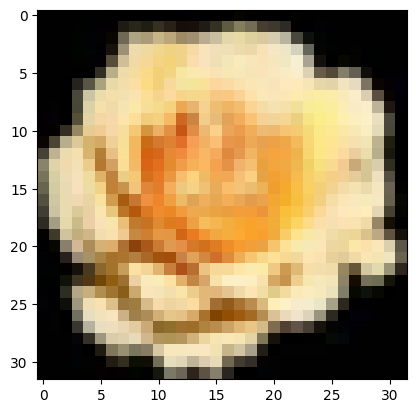

In [ ]:
# for dataset from CIFAR-100
#i = 15 #0
plt.imshow(x_test[i])

In [ ]:
cifar100_classes[y_test[i][0]]

'rose'

In [ ]:
# for CIFAR-100 example
np.random.seed(0)
explanation = explainer.explain(norm_image, threshold=.75, p_sample=.5, tau=0.25)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step


superpixels in the anchor

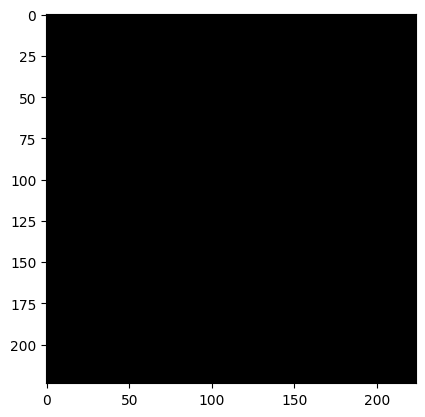

In [ ]:
plt.imshow(explanation.anchor)

a visualization of all the superpixels

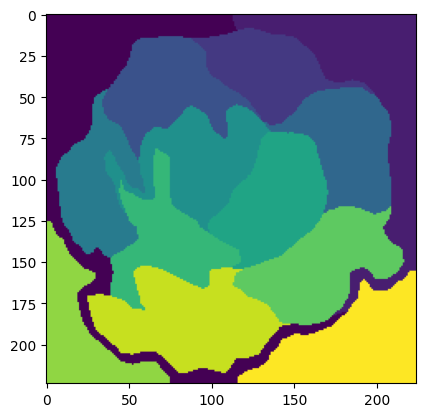

In [ ]:
plt.imshow(explanation.segments)

Create a heatmap visualization:

- For example, we can highlight the anchor regions in red overlay

In [ ]:
explanation.anchor.shape

(224, 224, 3)

In [ ]:
# create a mask for the anchor regions
anchor_mask = np.zeros(explanation.segments.shape, dtype=bool)
for sp in np.unique(explanation.anchor): # iterate through unique superpixel IDs  #np.unique(np.mean(explanation.anchor, axis=1)):
  anchor_mask[explanation.segments == sp] = True # compare segment IDs with superpixel IDs; assign True to matching segment

In [ ]:
anchor_mask.shape

(224, 224)

In [ ]:
# for example using CIFAR-100
# create an overlay by modifying the original image
overlay = resized_image.astype(np.uint8).copy()
overlay[anchor_mask] = [255, 0, 0] # red tint on anchor segments [R,G,B], highlight anchor regions in red

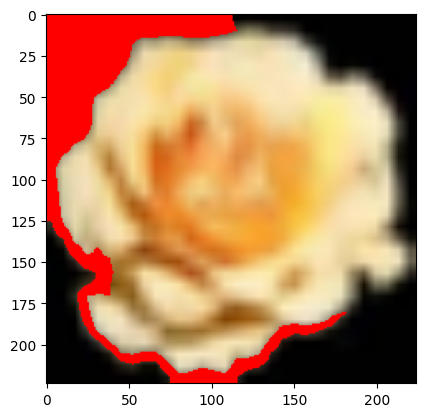

In [ ]:
plt.imshow(overlay)

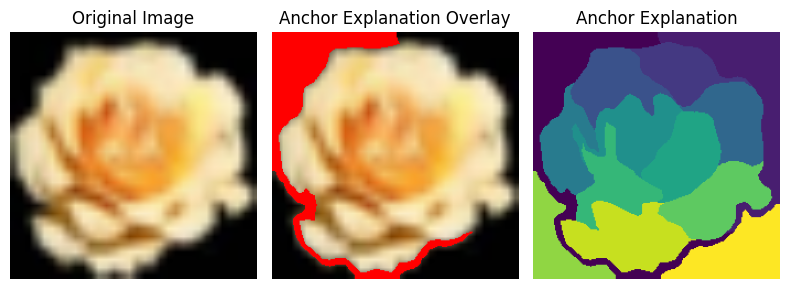

In [ ]:
# plot orginal and anchor overlay
fig, ax = plt.subplots(1, 3, figsize=(8,4))
ax[0].imshow(resized_image.astype(np.uint8))
ax[0].set_title("Original Image")
ax[0].axis('off')

ax[1].imshow(overlay)
ax[1].set_title("Anchor Explanation Overlay")
ax[1].axis('off')

ax[2].imshow(explanation.segments)
ax[2].set_title("Anchor Explanation")
ax[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# The 'explanation' object also provides metrics:
print("Precision: ", explanation.precision)
print("Coverage: ", explanation.coverage)
print("Anchor superpixels:", explanation.anchor)

Precision:  [1.]
Coverage:  1
Anchor superpixels: [[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
